# File and libraries

In [50]:
import pandas as pd
import numpy as np


#filepath=r'dataset/df_ecom_2_2_mv_input'
filepath=r'dataset/df_ecom_2_3_outliers_input'

file_tag = "Multicategory Store"

# DSLabs functions

In [51]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [52]:
%run "data_functions.py"


data_functions loaded


# Load

In [53]:
# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(f"{filepath}_test.csv")
    train= pd.read_csv(f"{filepath}_train.csv")

    sample=0.005
    df = df.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    
    # create sample df version of test/train for variance studies
    test_sample= test
    train_sample= train
    
else:
    df=pd.read_csv(f"{filepath}.csv")

    
    test= pd.read_csv(f"{filepath}_test.csv")
    train= pd.read_csv(f"{filepath}_train.csv")

    # create sample for variance studies
    sample=0.2
    test_sample = test.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train_sample = train.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)


 
target='is_purchase'

target_metric_2='precision'
target_metric='f2'
vars: list[str] = df.columns.to_list()


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188630 entries, 0 to 188629
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  188630 non-null  float64
 1   category_code_lvl_2  188630 non-null  float64
 2   price                188630 non-null  float64
 3   is_purchase          188630 non-null  int64  
 4   activity_in_session  188630 non-null  float64
 5   week_of_month        188630 non-null  int64  
 6   is_weekend           188630 non-null  int64  
 7   day                  188630 non-null  int64  
 8   brand_value          188630 non-null  float64
 9   product_category     188630 non-null  int64  
 10  time_of_day_sin      188630 non-null  float64
 11  time_of_day_cos      188630 non-null  float64
 12  day_of_week_sin      188630 non-null  float64
 13  day_of_week_cos      188630 non-null  float64
 14  hour_sin             188630 non-null  float64
 15  hour_cos             1

In [54]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (132041, 18)
Test shape: (56589, 18)


In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132041 entries, 0 to 132040
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  132041 non-null  float64
 1   category_code_lvl_2  132041 non-null  float64
 2   price                132041 non-null  float64
 3   activity_in_session  132041 non-null  float64
 4   week_of_month        132041 non-null  float64
 5   is_weekend           132041 non-null  float64
 6   day                  132041 non-null  float64
 7   brand_value          132041 non-null  float64
 8   product_category     132041 non-null  float64
 9   time_of_day_sin      132041 non-null  float64
 10  time_of_day_cos      132041 non-null  float64
 11  day_of_week_sin      132041 non-null  float64
 12  day_of_week_cos      132041 non-null  float64
 13  hour_sin             132041 non-null  float64
 14  hour_cos             132041 non-null  float64
 15  min_sin              1

# Feat 1 - Dropping Low Variance Variables

## Feat 1 - Study Low Variance Variables and Threshold

using sampled dataframe due to heavy processing

In [8]:
max_thresh=0.5
lag_variance=0.025

### target_metric_2 - precision

Testing threshold: 0.025
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.025: {'accuracy': [0.5276133250861536, 0.7641601131041795], 'recall': [0.4715261958997722, 0.02201974183750949], 'precision': [0.2390300230946882, 0.3841059602649007], 'auc': [0.5080768144073318, 0.5056545789689677], 'f1': [0.31724137931034485, 0.04165170556552962], 'f2': [0.39473684210526316, 0.027135772433798073]}
Evaluation for precision: [0.2390300230946882, 0.3841059602649007]
Testing threshold: 0.05
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.05: {'accuracy': [0.5276133250861536, 0.7641601131041795], 'recall': [0.4715261958997722, 0.02201974183750949], 'precision': [0.2390300230946882, 0.3841059602649007], 'auc': [0.5080768144073318, 0.5056545789689677], 'f1': [0.31724137931034485, 0.04165170556552962], 'f2': [0.39473684210526316, 0.027135772433798073]}
Evaluation for precision: [0.2390300230946882, 0.3841059602649007]


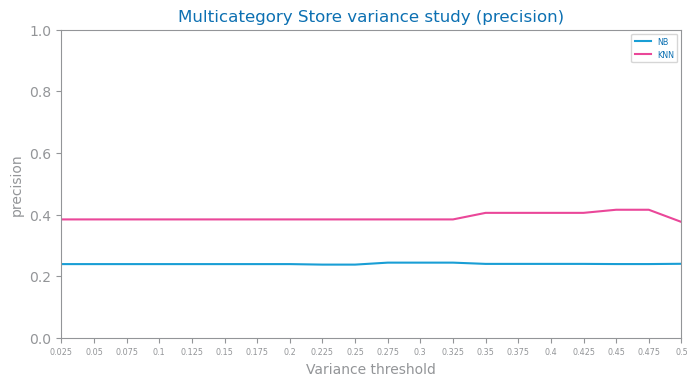

In [9]:
# modified study_variance_for_feature_selection() in dslabs functions to keep minimum variables and print metrics (due to error)
if evaluate==True:

    eval_metric = target_metric_2
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_variance_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        max_threshold=max_thresh,
        lag=lag_variance,
        metric=eval_metric,
        file_tag=file_tag,
        min_features_to_keep = 10  # Minimum features safeguard

    )
    show()

### eval_metric_2 - f2

Testing threshold: 0.025
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.025: {'accuracy': [0.5276133250861536, 0.6763276486701423], 'recall': [0.4715261958997722, 0.22892938496583143], 'precision': [0.2390300230946882, 0.2697986577181208], 'auc': [0.5080768144073318, 0.5204879563318158], 'f1': [0.31724137931034485, 0.2476894639556377], 'f2': [0.39473684210526316, 0.23608174770965468]}
Evaluation for f2: [0.39473684210526316, 0.23608174770965468]
Testing threshold: 0.05
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.05: {'accuracy': [0.5276133250861536, 0.6763276486701423], 'recall': [0.4715261958997722, 0.22892938496583143], 'precision': [0.2390300230946882, 0.2697986577181208], 'auc': [0.5080768144073318, 0.5204879563318158], 'f1': [0.31724137931034485, 0.2476894639556377], 'f2': [0.39473684210526316, 0.23608174770965468]}
Evaluation for f2: [0.39473684210526316, 0.23608174770965468]
Testing thresh

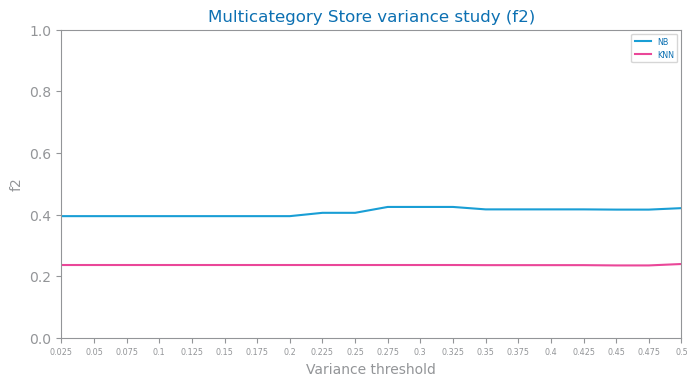

In [10]:
# modified study_variance_for_feature_selection() in dslabs functions to keep minimum variables and print metrics (due to error)
if evaluate==True:

    eval_metric = target_metric
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_variance_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        max_threshold=max_thresh,
        lag=lag_variance,
        metric=eval_metric,
        file_tag=file_tag,
        min_features_to_keep = 10  # Minimum features safeguard

    )
    show()

## Feat 1 strategy Application

## Feat 1 strategy Application

In [56]:
from pandas import DataFrame, Index

def select_low_variance_variables(
    data: DataFrame, 
    max_threshold: float, 
    target: str = "is_purchase",
    min_features_to_keep: int = 10,  
    exclude: list[str] = ["day_of_year"]
) -> list:
    # Exclui as colunas que não devem ser consideradas
    data_filtered = data.drop(columns=exclude, errors='ignore')
    
    summary5: DataFrame = data_filtered.describe()

    # Calcula a variância
    variances = summary5.loc["std"] ** 2

    # Identifica as variáveis a serem removidas
    vars2drop: Index[str] = summary5.columns[variances < max_threshold]

    # Garante que a coluna alvo não seja removida
    if target in vars2drop:
        vars2drop = vars2drop.drop(target)

    # Garantia de que um número mínimo de recursos seja retido
    remaining_features = data_filtered.drop(vars2drop, axis=1).shape[1]
    if remaining_features < min_features_to_keep:
        print(f"Threshold too strict, keeping at least {min_features_to_keep} features.")
        vars2drop = summary5.columns[variances < max_threshold]
        remaining_features = data_filtered.drop(vars2drop, axis=1).shape[1]

        # Se ainda estiver muito poucos recursos, não remover nada
        if remaining_features < min_features_to_keep:
            print(f"Warning: Dropping too many features even with adjusted threshold.")
            vars2drop = Index([])  # Não remover nenhuma variável

    print(f"Variance threshold: {max_threshold}, Remaining features: {remaining_features}")
    print(f"Variables to drop: {list(vars2drop)}")

    return list(vars2drop.values)

def apply_remove_low_variance_variables(
    data: DataFrame,
    max_threshold=0.5,
    min_features_to_keep=10,
    target='is_purchase'
) -> DataFrame:
    
    # Chama a função para selecionar variáveis de baixa variância
    vars2drop: list[str] = select_low_variance_variables(
        data, 
        max_threshold=max_threshold, 
        min_features_to_keep=min_features_to_keep, 
        target=target
    )
    
    print("Columns to drop:", vars2drop)

    # Remove as colunas de baixa variância do DataFrame
    df_vars_drop = data.drop(columns=vars2drop, errors='ignore')
    
    print("Remaining columns:", df_vars_drop.columns)

    return df_vars_drop



In [57]:

def apply_strategy_1(data: DataFrame) -> DataFrame:
    # Defina o target aqui ou passe-o como parâmetro
    target = 'is_purchase'
    # Aplicando a estratégia de remoção de variáveis de baixa variância
    df_copy = apply_remove_low_variance_variables(data, max_threshold=0.3, target=target, min_features_to_keep=10)
    
    return df_copy

# Exemplo de uso
# Supondo que 'df' esteja definido anteriormente
df_1 = apply_strategy_1(df)
print(df_1.describe())

Variance threshold: 0.3, Remaining features: 17
Variables to drop: ['is_weekend']
Columns to drop: ['is_weekend']
Remaining columns: Index(['category_code_lvl_1', 'category_code_lvl_2', 'price', 'is_purchase',
       'activity_in_session', 'week_of_month', 'day', 'brand_value',
       'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos'],
      dtype='object')
       category_code_lvl_1  category_code_lvl_2          price    is_purchase  \
count        188630.000000        188630.000000  188630.000000  188630.000000   
mean              0.456391             5.543090     322.325152       0.157202   
std               0.825113             5.271548     270.257377       0.363992   
min               0.000000             0.000000       0.870000       0.000000   
25%               0.000000             3.000000     128.670000       0.000000   
50%               0.000000             3.000000  

## Feat 1 train/test split 

Labels=[0, 1]


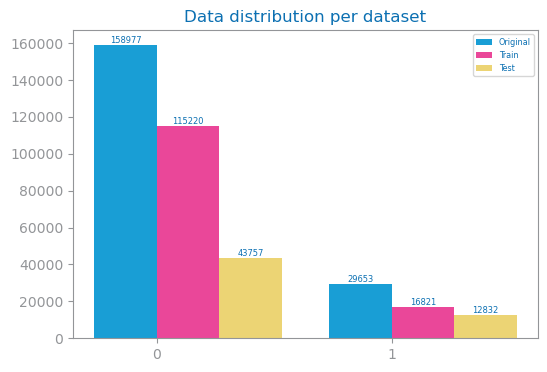

In [58]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    from numpy import array, ndarray


    y_1, X_1, labels, values = define_target_and_prepare_data(df_1, target)



    train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=df_1.columns), y_1, data_columns=df_1.columns, target_column=target)

    # Distribution check
    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Feat 1 evaluate

### optimize for target_metric_2 - precision

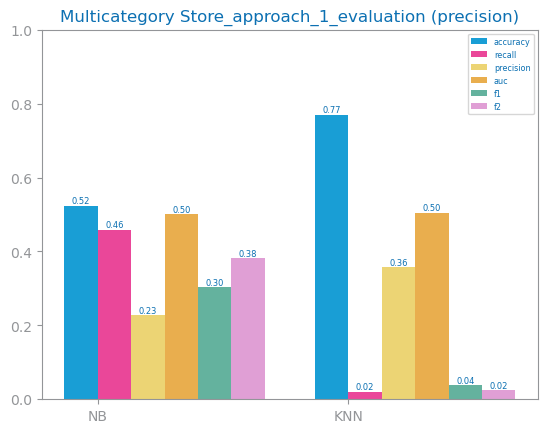

In [14]:
if evaluate==True:

    # evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
    # removed Multinomial from run_NB function because dataset has negative values

    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_purchase', metric=target_metric_2)
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag}_approach_1_evaluation ({target_metric_2})", percentage=True
    )
    savefig(f"images/{file_tag}_feat_eng_approach_1_eval_{target_metric_2}.png")
    show()

### optimize for target metric - f2


In [20]:

def apply_strategy_1(data: DataFrame) -> DataFrame:
    # Defina o target aqui ou passe-o como parâmetro
    target = 'is_purchase'
    # Aplicando a estratégia de remoção de variáveis de baixa variância
    df_copy = apply_remove_low_variance_variables(data, max_threshold=0.3, target=target, min_features_to_keep=10)
    
    return df_copy

# Exemplo de uso
# Supondo que 'df' esteja definido anteriormente
df_1 = apply_strategy_1(df)
print(df_1.describe())

Variance threshold: 0.3, Remaining features: 17
Variables to drop: ['is_weekend']
Columns to drop: ['is_weekend']
Remaining columns: Index(['category_code_lvl_1', 'category_code_lvl_2', 'price', 'is_purchase',
       'activity_in_session', 'week_of_month', 'day', 'brand_value',
       'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos'],
      dtype='object')
       category_code_lvl_1  category_code_lvl_2          price    is_purchase  \
count        188630.000000        188630.000000  188630.000000  188630.000000   
mean              0.456391             5.543090     322.325152       0.157202   
std               0.825113             5.271548     270.257377       0.363992   
min               0.000000             0.000000       0.870000       0.000000   
25%               0.000000             3.000000     128.670000       0.000000   
50%               0.000000             3.000000  

Labels=[0, 1]


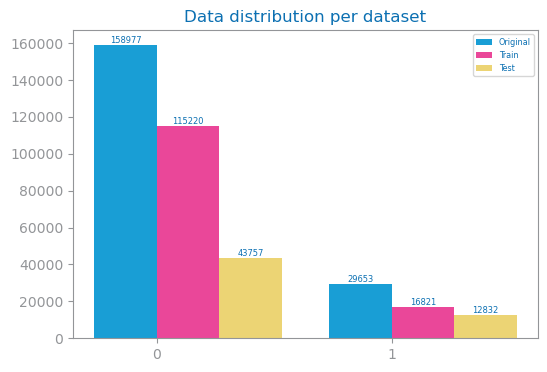

In [21]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    from numpy import array, ndarray


    y_1, X_1, labels, values = define_target_and_prepare_data(df_1, target)



    train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=df_1.columns), y_1, data_columns=df_1.columns, target_column=target)

    # Distribution check
    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

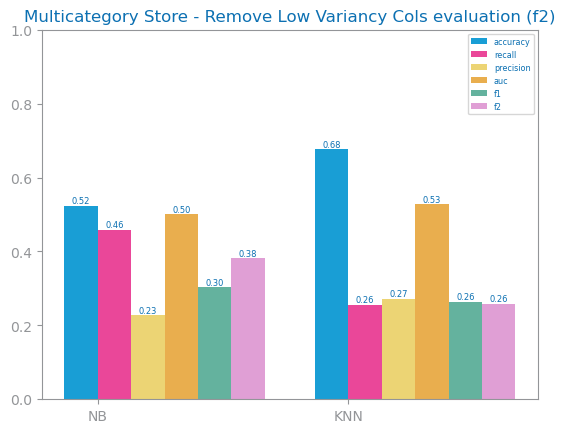

In [22]:
if evaluate==True:

    # evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
    # removed Multinomial from run_NB function because dataset has negative values

    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_purchase', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag} - Remove Low Variancy Cols evaluation ({target_metric})", percentage=True
    )
    savefig(f"images/{file_tag}_feat_eng_approach_1_eval_{target_metric}.png")
    show()

# Feat 2 - Dropping Redundant Variables


In [211]:
test.columns

Index(['category_code_lvl_1', 'category_code_lvl_2', 'price',
       'activity_in_session', 'week_of_month', 'is_weekend', 'day',
       'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos', 'is_purchase'],
      dtype='object')

In [24]:

def select_redundant_variables(
    data: DataFrame, 
    min_threshold: float = 0.90, 
    target: str = "class", 
    exclude: list[str] = ["day_of_year"]  # Columns to exclude from redundancy check
) -> list:
    # Exclude the columns that should not be considered (like 'day_of_month')
    data_filtered = data.drop(columns=[target] + exclude, errors='ignore')

    # Calculate the correlation matrix
    corr_matrix: DataFrame = abs(data_filtered.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []

    # Iterate over the variables and check correlations
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)  # Remove self-correlation
        if len(vars_corr) > 1:  # Check if more than one correlated variable
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)

    return vars2drop


def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    # Generate the range of redundancy thresholds to test
    options: list[float] = [
        round(min_threshold + i * lag, 3)
        for i in range(ceil((1 - min_threshold) / lag) + 1)
    ]

    # Ensure 'target' column is present and drop it for correlation calculation
    df: DataFrame = train.drop(target, axis=1, inplace=False)
    print(f"Columns in the train dataset: {df.columns.tolist()}")  # Debugging step

    # Calculate the correlation matrix
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    print(f"Variables considered for correlation: {variables.tolist()}")  # Debugging step

    results: dict[str, list] = {"NB": [], "KNN": []}
    
    for thresh in options:
        vars2drop: list = []
        
        # Loop through the variables to identify correlated features
        for v1 in variables:
            # Get features correlated with the current variable
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            
            # Check if the current variable is in the correlation list before trying to drop it
            if v1 in vars_corr:
                vars_corr.drop(v1, inplace=True)
            
            # If other variables are highly correlated with v1, consider them for removal
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        print(f"Variables to drop at threshold {thresh}: {vars2drop}")  # Debugging step
        
        # Drop the selected redundant variables from train and test datasets
        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)

        # Evaluate the approach using the current feature set
        eval: dict | None = evaluate_approach(train_copy, test_copy, target=target, metric=metric)

        # Check if evaluation returned results
        if eval:
            print(f"Evaluation results at threshold {thresh}: {eval}")
            if metric in eval:
                print(f"Evaluation for {metric}: {eval[metric]}")
                results["NB"].append(eval[metric][0])
                results["KNN"].append(eval[metric][1])
            else:
                print(f"Metric '{metric}' not found in evaluation results at threshold {thresh}.")
                results["NB"].append(None)
                results["KNN"].append(None)
        else:
            print(f"Evaluation failed or returned empty at threshold {thresh}.")
            results["NB"].append(None)
            results["KNN"].append(None)

    # Optional: Save or plot the results after evaluation
    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
    return results


In [29]:
min_thresh=0.7
lag_redundacy=0.025

In [27]:
# At the start of the for loop in study_redundancy_for_feature_selection
print(f"Initial number of features: {df.shape[1]}")
print(f"Redundancy threshold: {min_thresh}")

Initial number of features: 18
Redundancy threshold: 0.7


### precision study

Columns in the train dataset: ['category_code_lvl_1', 'category_code_lvl_2', 'price', 'activity_in_session', 'week_of_month', 'is_weekend', 'day', 'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables considered for correlation: ['category_code_lvl_1', 'category_code_lvl_2', 'price', 'activity_in_session', 'week_of_month', 'is_weekend', 'day', 'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables to drop at threshold 0.7: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Evaluation results at threshold 0.7: {'accuracy': [0.5274365998056022, 0.7646902889458337], 'recall': [0.47266514806378135, 0.02126044039483675], 'precision': [0.23923904688701, 0.3971631205673759], 'auc': [0.5083583715673047, 0.5057355985228819], 'f1': [0.3176830824189844, 0.0403

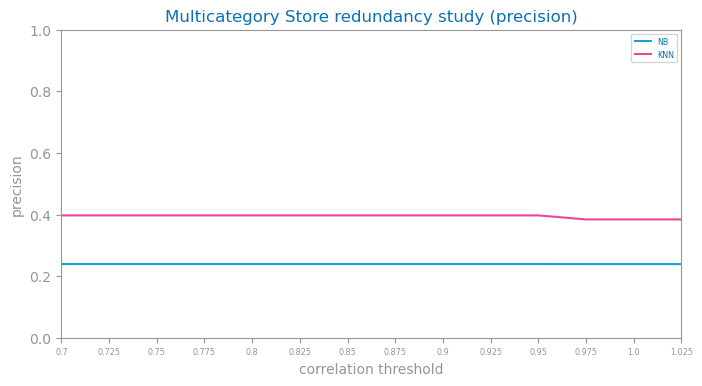

In [31]:
if evaluate==True:

    # modified study_variance_for_feature_selection() in dslabs functions to keep minimum variables and print metrics (due to error)


    eval_metric = target_metric_2
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_redundancy_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        min_threshold = min_thresh,
        lag = lag_redundacy,
        metric=eval_metric,
        file_tag=file_tag
        )
    show()

### f2 study

Columns in the train dataset: ['category_code_lvl_1', 'category_code_lvl_2', 'price', 'activity_in_session', 'week_of_month', 'is_weekend', 'day', 'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables considered for correlation: ['category_code_lvl_1', 'category_code_lvl_2', 'price', 'activity_in_session', 'week_of_month', 'is_weekend', 'day', 'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables to drop at threshold 0.7: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Evaluation results at threshold 0.7: {'accuracy': [0.5274365998056022, 0.6509675709110189], 'recall': [0.47266514806378135, 0.2737281700835232], 'precision': [0.23923904688701, 0.2614213197969543], 'auc': [0.5083583715673047, 0.5195659162061057], 'f1': [0.3176830824189844, 0.26743

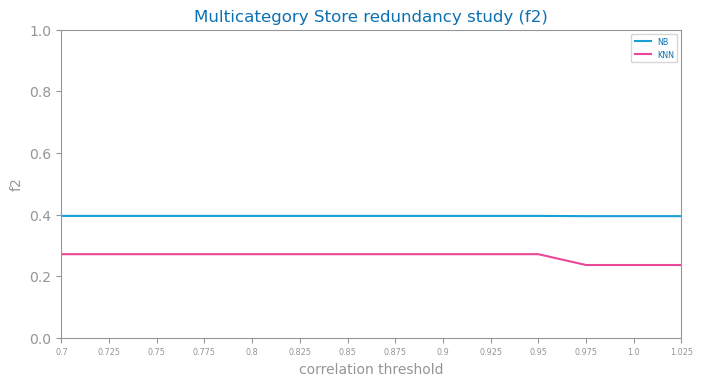

In [32]:
if evaluate==True:

    # modified study_variance_for_feature_selection() in dslabs functions to keep minimum variables and print metrics (due to error)


    eval_metric = target_metric
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_redundancy_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        min_threshold = min_thresh,
        lag = lag_redundacy,
        metric=eval_metric,
        file_tag=file_tag,
    )
    show()

## Feat 2 - Study redundant variables and threshold

## Feat 2 strategy aplication

In [33]:

def select_redundant_variables(
    data: DataFrame, 
    min_threshold: float = 1, 
    target: str = "is_purchase", 
    exclude: list[str] = ["day_of_year"]  # Columns to exclude from redundancy check
) -> list:
    # Exclude the columns that should not be considered (like 'day_of_month')
    data_filtered = data.drop(columns=[target] + exclude, errors='ignore')

    # Calculate the correlation matrix
    corr_matrix: DataFrame = abs(data_filtered.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []

    # Iterate over the variables and check correlations
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)  # Remove self-correlation
        if len(vars_corr) > 1:  # Check if more than one correlated variable
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)

    return vars2drop

In [34]:
from pandas import DataFrame, Series, Index

def select_redundant_variables(
    data: DataFrame, 
    min_threshold: float = 1, 
    target: str = "is_purchase", 
    exclude: list[str] = ["day_of_year"]
) -> list:
    print("Iniciando a função select_redundant_variables...")
    # Criar uma cópia do DataFrame e remover as colunas que não devem ser consideradas
    data_filtered = data.drop(columns=[target] + exclude, errors='ignore')

    # Calcular a matriz de correlação
    corr_matrix: DataFrame = abs(data_filtered.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []

    # Iterar sobre as variáveis e verificar correlações
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)  # Remover auto-correlação
        if len(vars_corr) > 1:  # Verificar se mais de uma variável correlacionada
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)

    print("Saindo da função select_redundant_variables com vars2drop:", vars2drop)
    return vars2drop

def apply_remove_redundant_variables(df: DataFrame, min_threshold=0.8, exclude=['day_of_year'], target='is_purchase') -> DataFrame:
    df_copy = df.copy()

    # Verifique se as colunas alvo estão corretas
    print(f"Excluindo as seguintes colunas: {exclude + [target]}")  # Debugging step

    # Chame a função para obter as colunas a serem removidas
    vars2drop = select_redundant_variables(df_copy, min_threshold=min_threshold, exclude=exclude, target=target)
    
    # Imprimindo informações detalhadas
    print(f"Variance threshold: {min_threshold}, Variables to drop: {vars2drop}")
    
    # Verifique se as colunas a serem removidas estão realmente presentes
    missing_vars = [var for var in vars2drop if var not in df_copy.columns]
    if missing_vars:
        print(f"As seguintes colunas não estão presentes no DataFrame: {missing_vars}")

    # Remover as colunas do DataFrame, mas manter a coluna target
    df_vars_drop = df_copy.drop(columns=vars2drop, errors='ignore')
    print("Columns to drop:", vars2drop)
    print("Remaining columns:", df_vars_drop.columns)

    return df_vars_drop


In [74]:

def apply_strategy_2(df: DataFrame, target='is_purchase'):
    print(f"Applying strategy 2 with target '{target}'...")
    df_copy = apply_remove_redundant_variables(df, min_threshold=0.7, exclude=['day_of_year'], target=target)
    print("Final DataFrame after applying strategy 2:")
    print(df_copy)
    return df_copy

# Chamada da função com o seu DataFrame df
result_df = apply_strategy_2(df, target='is_purchase')
print(result_df)

Applying strategy 2 with target 'is_purchase'...
Excluindo as seguintes colunas: ['day_of_year', 'is_purchase']
Iniciando a função select_redundant_variables...
Saindo da função select_redundant_variables com vars2drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Variance threshold: 0.7, Variables to drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Columns to drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Remaining columns: Index(['price', 'is_purchase', 'activity_in_session', 'week_of_month',
       'is_weekend', 'day', 'brand_value', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos', 'min_sin', 'min_cos'],
      dtype='object')
Final DataFrame after applying strategy 2:
         price  is_purchase  activity_in_session  week_of_month  is_weekend  \
0       261.55            0                  3.0              2           0   
3655    915.08           

In [35]:
from pandas import DataFrame, Series
from sklearn.preprocessing import MinMaxScaler

def apply_strategy_2(df):


    df_copy = apply_remove_redundant_variables(df, min_threshold=0.7, exclude=['day_of_year'], target=target)


    return df_copy


df_2=df.copy()

df_2=apply_strategy_2(df_2)

Excluindo as seguintes colunas: ['day_of_year', 'is_purchase']
Iniciando a função select_redundant_variables...
Saindo da função select_redundant_variables com vars2drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Variance threshold: 0.7, Variables to drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Columns to drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Remaining columns: Index(['price', 'is_purchase', 'activity_in_session', 'week_of_month',
       'is_weekend', 'day', 'brand_value', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos', 'min_sin', 'min_cos'],
      dtype='object')


In [112]:
df_2.head()

,price,is_purchase,activity_in_session,week_of_month,is_weekend,day,brand_value,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin,min_cos
0,949.47,0,3.0,1,0,1,779.2,0.624,-0.781,-0.775,-0.632,0.966,0.259,-0.105,0.995
1408,170.14,0,25.0,1,0,1,282.5,-0.975,0.221,-0.775,-0.632,-0.966,-0.259,-0.208,-0.978
1407,44.53,1,0.0,1,0,1,51.1,-0.975,0.221,-0.775,-0.632,0.000,-1.000,-0.669,0.743
1406,211.32,0,1.0,1,0,1,173.5,-0.975,0.221,-0.775,-0.632,-0.866,-0.500,0.105,-0.995
1405,453.16,1,3.0,1,0,1,779.2,-0.624,-0.781,-0.775,-0.632,-0.707,0.707,0.407,-0.914


## Feat 2 train/test split 

Labels=[0, 1]


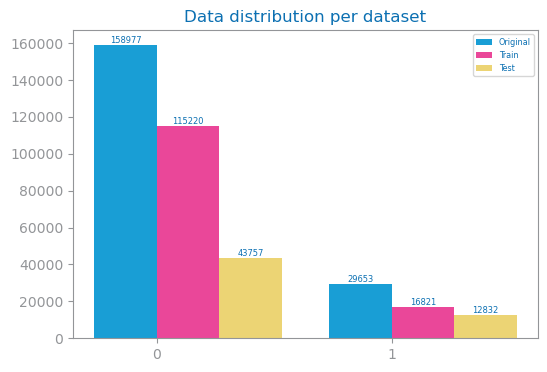

In [36]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    from numpy import array, ndarray


    y_2, X_2, labels, values = define_target_and_prepare_data(df_2, target)



    train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=df_2.columns), y_2, data_columns=df_2.columns, target_column=target)

    # Distribution check
    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Feat 2 evaluate

### eval target_metric_2 - precision

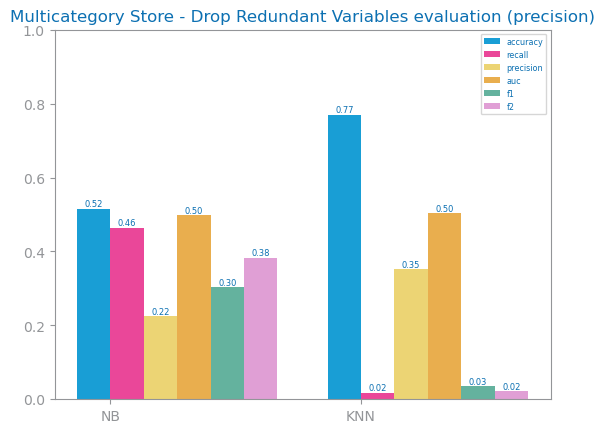

In [37]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_purchase', metric=target_metric_2)
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag} - Drop Redundant Variables evaluation ({target_metric_2})", percentage=True
    )
    savefig(f"images/{file_tag}_feat_eng_approach_2_evaluation_{target_metric_2}.png")
    show()

### eval target_metric - f2

In [38]:
from pandas import DataFrame, Series
from sklearn.preprocessing import MinMaxScaler

def apply_strategy_2(df):


    df_copy = apply_remove_redundant_variables(df, min_threshold=0.9, exclude=['day_of_year'], target=target)


    return df_copy


df_2=df.copy()

df_2=apply_strategy_2(df_2)

Excluindo as seguintes colunas: ['day_of_year', 'is_purchase']
Iniciando a função select_redundant_variables...
Saindo da função select_redundant_variables com vars2drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Variance threshold: 0.9, Variables to drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Columns to drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Remaining columns: Index(['price', 'is_purchase', 'activity_in_session', 'week_of_month',
       'is_weekend', 'day', 'brand_value', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos', 'min_sin', 'min_cos'],
      dtype='object')


Labels=[0, 1]


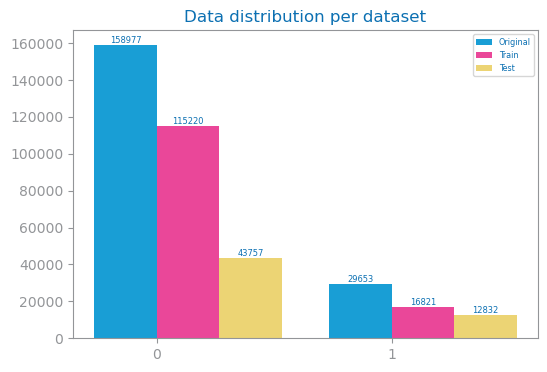

In [39]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    from numpy import array, ndarray


    y_2, X_2, labels, values = define_target_and_prepare_data(df_2, target)



    train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=df_2.columns), y_2, data_columns=df_2.columns, target_column=target)

    # Distribution check
    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

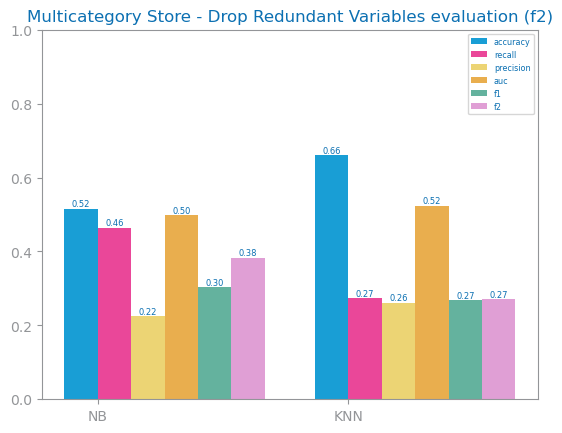

In [40]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_purchase', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag} - Drop Redundant Variables evaluation ({target_metric})", percentage=True
    )
    savefig(f"images/{file_tag}_feat_eng_approach_2_evaluation_{target_metric}.png")
    show()

In [78]:
train_2.head()

,price,activity_in_session,week_of_month,is_weekend,day,brand_value,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin,min_cos
0,261.55,3.0,2.0,0.0,8.0,455.0,0.624,-0.781,-0.775,-0.632,0.259,-0.966,0.669,-0.743
1,915.08,4.0,2.0,0.0,8.0,779.2,-0.975,0.221,-0.775,-0.632,-0.966,-0.259,0.866,0.500
2,2.63,2.0,2.0,0.0,8.0,16.9,0.624,-0.781,-0.775,-0.632,0.966,-0.259,0.105,0.995
3,980.21,4.0,2.0,0.0,8.0,779.2,0.624,-0.781,-0.775,-0.632,0.966,-0.259,0.208,0.978
4,194.89,4.0,2.0,0.0,8.0,282.5,-0.975,0.221,-0.775,-0.632,-0.707,-0.707,0.914,0.407


# Approach uplift comparison

## uplift df

In [42]:
if evaluate == True:
    
    algorithms = ['Naive Bayes', 'KNN']

    # Create DataFrames for eval_1 and eval_2
    df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
    df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

    # Calculate uplift
    df_uplift = df_eval_2 - df_eval_1



    # Combine everything into one DataFrame (without misalignment issues)
    comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
    comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



    # Display the DataFrame
    display(comparison_df)

Approach 1                                                    \
              accuracy    recall precision       auc        f1        f2   
Naive Bayes   0.523777  0.458619  0.227334  0.500752  0.303985  0.381079   
KNN           0.675909  0.256001  0.271982  0.527525  0.263749  0.259045   

            Approach 2                                                   \
              accuracy    recall precision       auc        f1       f2   
Naive Bayes   0.515418  0.464698  0.224883  0.497495  0.303090  0.38301   
KNN           0.659952  0.273847  0.261478  0.523513  0.267519  0.27128   

               Uplift                                                    
             accuracy    recall precision       auc        f1        f2  
Naive Bayes -0.008359  0.006079 -0.002451 -0.003257 -0.000895  0.001931  
KNN         -0.015957  0.017846 -0.010504 -0.004012  0.003770  0.012235

# Analysis

Comparing approaches:
- No improvement (actuall loss)

Comparing with previous dataset:
- For now lets go with feature enginerring dataset

Decision:
- In balancing, feature engineering values dataset

# save to csv

In [43]:
if test_data==False:
    
    
    data_save=df.copy()

    data_save=apply_strategy_1(data_save)
        
    data_save.to_csv(f"dataset/df_ecom_2_5_feat_eng_input.csv", index=False)


    print(data_save.columns)



Variance threshold: 0.3, Remaining features: 17
Variables to drop: ['is_weekend']
Columns to drop: ['is_weekend']
Remaining columns: Index(['category_code_lvl_1', 'category_code_lvl_2', 'price', 'is_purchase',
       'activity_in_session', 'week_of_month', 'day', 'brand_value',
       'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos'],
      dtype='object')
Index(['category_code_lvl_1', 'category_code_lvl_2', 'price', 'is_purchase',
       'activity_in_session', 'week_of_month', 'day', 'brand_value',
       'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos'],
      dtype='object')


## train test csv

In [44]:
if test_data==False:
    

    data_save_copy=data_save.copy()

    
    y, X, labels, class_counts = define_target_and_prepare_data(data_save_copy, target=target)

    train, test = split_data_save_csv(pd.DataFrame(X, columns=data_save_copy.columns), y, data_columns=data_save_copy.columns, target_column=target)  
    
    train.to_csv(f"dataset/df_ecom_2_5_feat_eng_input_train.csv", index=False)
    print(train.columns)
    
    test.to_csv(f"dataset/df_ecom_2_5_feat_eng_input_test.csv", index=False)
    print(test.columns)

Labels=[0, 1]
Index(['category_code_lvl_1', 'category_code_lvl_2', 'price',
       'activity_in_session', 'week_of_month', 'day', 'brand_value',
       'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos', 'is_purchase'],
      dtype='object')
Index(['category_code_lvl_1', 'category_code_lvl_2', 'price',
       'activity_in_session', 'week_of_month', 'day', 'brand_value',
       'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos', 'is_purchase'],
      dtype='object')
